In [273]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from scipy.stats import linregress
import random
import scipy

In [ ]:
### CONFIGURAÇÔES
precision = torch.complex128  # Precisão dos cálculos
# precision= torch.float64  # Precisão dos cálculos
ns = [10, 20, 50, 100] + list(range(100, 1100, 100)) #+ list(range(1200, 3300, 500)) # Tamanhos das matrizes usadas nos cálculos
colorSymetric = '#4287f5'
colorNormal = "#e61e1e"

# Questão 1. Redução à forma de Hessemberg.

## a) Cálculo dos refletores.

- Foi usado o algoritmo 26.1 proposto por Trefethen & Bau. 

In [275]:
def HS(A: torch.Tensor, computeQ=True):
    """
    Transforma uma matriz A em forma de Hessenberg usando reflexões de Householder.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada real ou complexa de dimensão (m x m)

    Retorna:
    - v_list: lista de vetores de Householder aplicados (um por iteração)
    - H: matriz de Hessenberg superior resultante (semelhante a A)
    - Q: matriz ortogonal/acumulada das reflexões, tal que Q^T A Q = H
    """
    m = A.shape[0]
    H = A.clone()  # Cópia da matriz original para evitar modificações diretas
    v_list = []    # Lista para armazenar os vetores de Householder
    if computeQ: Q = torch.eye(m, dtype=A.dtype, device=A.device)  # Inicializa Q como identidade

    for k in range(m - 2):
        # Seleciona a coluna abaixo da diagonal para zerar
        x = H[k+1 : m, k]
        v_k = x.clone()

        # Calcula o vetor de Householder
        norm_x = torch.norm(x)
        if x[0] != 0:
            phase = x[0] / torch.abs(x[0])  # Fator de fase: x[0]/|x[0]|
            v_k[0] += phase * norm_x
        else:
            v_k[0] += norm_x

        # Normaliza v_k
        v_k = v_k / torch.norm(v_k)
        v_list.append(v_k)

        # Aplica reflexão de Householder à esquerda: H = (I - 2vvᵗ) H
        left_mul = torch.matmul(v_k.conj().unsqueeze(0), H[k+1 : m, k : m])
        H[k+1 : m, k : m] -= 2 * torch.ger(v_k, left_mul.squeeze(0))

        # Aplica reflexão à direita: H = H (I - 2vvᵗ)
        right_mul = torch.matmul(H[:, k+1 : m], v_k)
        H[:, k+1 : m] -= 2 * torch.ger(right_mul, v_k.conj())

        if computeQ:
            # Atualiza a matriz Q acumulando as transformações
            q_mul = torch.matmul(Q[:, k+1:m], v_k)
            Q[:, k+1:m] -= 2 * torch.ger(q_mul, v_k.conj())
    
    if computeQ:
        return v_list, H, Q
    else:
        return v_list, H

In [276]:
def norm1(A, H, Q):
    norm = torch.norm(A - Q @ H @ Q.conj().T).item()
    return norm

def norm2(Q):
    norm = torch.norm(Q.conj().T @ Q - torch.eye(Q.shape[0], dtype=Q.dtype, device=Q.device)).item()
    return norm

## b) Verificação da função

- Aqui iremos verificar alguns pontos:
    - $||A - QHQ^*||$ deve resultar um valor próximo de zero
    - $||Q^*Q - I||$ também deve estar próximo de zero

- Para cada uma dessas condições, utilizarei várias matrizes A: simétricas e não simétricas, de diferentes tamanhos.

- Os gráficos mostram que os erros estão baixos, ou seja, o algoritmo se mostra promissor.

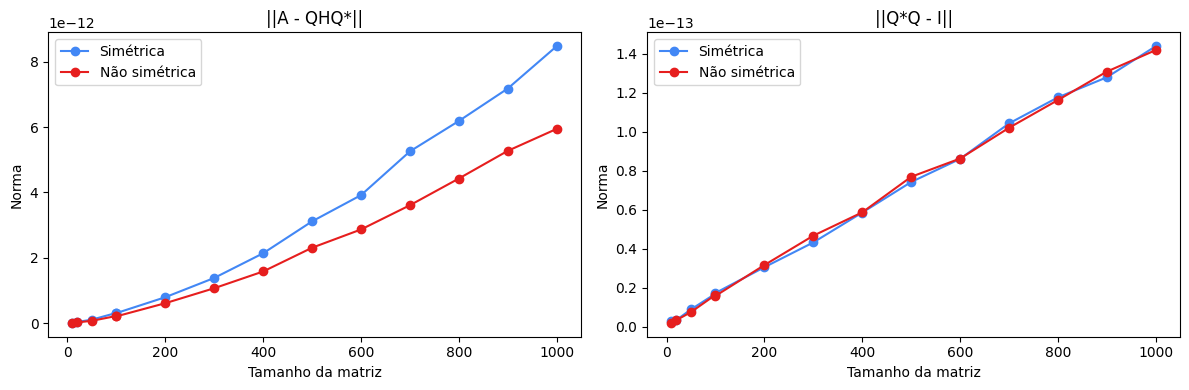

In [277]:
list_norm1 = [[], []]  # [simétrica, não simétrica]
list_norm2 = [[], []]  # [simétrica, não simétrica]
for tamanho in ns:
    A = torch.randn((tamanho, tamanho), dtype=precision)
    
    # Tornar simétrica
    A_simetrica = A + A.conj().T

    _, H, Q = HS(A)
    _, H_simetrica, Q_simetrica = HS(A_simetrica)

    # norm1 = ||A - Q H Q^T||
    norm1A = norm1(A, H, Q)
    norm1A_simetrica = norm1(A_simetrica, H_simetrica, Q_simetrica)

    # norm2 = ||Q^T Q - I||
    norm2A = norm2(Q)
    norm2A_simetrica = norm2(Q_simetrica)

    list_norm1[0].append(norm1A_simetrica)
    list_norm1[1].append(norm1A)
    list_norm2[0].append(norm2A_simetrica)
    list_norm2[1].append(norm2A)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(ns, list_norm1[0], '-o', label="Simétrica", color=colorSymetric)
plt.plot(ns, list_norm1[1], '-o',label="Não simétrica", color=colorNormal)
plt.title('||A - QHQ*||')
plt.xlabel('Tamanho da matriz')
plt.ylabel('Norma')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ns, list_norm2[0], '-o', label="Simétrica", color=colorSymetric)
plt.plot(ns, list_norm2[1], '-o', label="Não simétrica", color=colorNormal)
plt.title('||Q*Q - I||')
plt.ylabel('Norma')
plt.xlabel('Tamanho da matriz')
plt.legend()

plt.tight_layout()
plt.show()


## c) Complexidade

- Foram testadas matrizes de tamanhos variando de 10 a 3000. Com passos cada vez maiores : 10, 20, 50, 100, ...
- Para cada matriz é anotado o tempo de execução, ao final criando um gráfico com todos os tempos.
- Por fim, é usado um regressor linear para estimar a ordem da complexidade da função obtida, ou seja, do algoritmo desenvolvido. 
- A teoria nos mostra que a ordem de complexidade do algoritmo normal para a decomposição de Hessenberg é de aproximadamente $O(\frac{10}{3}n^3)$. Porém, devemos nos atentar que, quando tentamos estimar a ordem de complexidade usando o tempo de execução, a forma como o algoritmo é computado é importante. Por exemplo, um pode computar com apenas um thread da CPU, enquanto outro pode usar, para o mesmo cálculo, toda a sua GPU. Este problema de estimar se torna ainda pior quando pensamos em diferentes arquiteturas de computadores.
- Em meu computador, é estimado aproximadamente $O(n^{1.87})$

n = 10, tempo médio algoritmo normal = 0.009126 segundos
n = 20, tempo médio algoritmo normal = 0.020298 segundos
n = 50, tempo médio algoritmo normal = 0.057050 segundos
n = 100, tempo médio algoritmo normal = 0.137865 segundos
n = 100, tempo médio algoritmo normal = 0.147229 segundos
n = 200, tempo médio algoritmo normal = 0.521097 segundos
n = 300, tempo médio algoritmo normal = 1.348422 segundos
n = 400, tempo médio algoritmo normal = 2.358534 segundos
n = 500, tempo médio algoritmo normal = 3.815297 segundos
n = 600, tempo médio algoritmo normal = 6.071535 segundos
n = 700, tempo médio algoritmo normal = 7.564438 segundos
n = 800, tempo médio algoritmo normal = 11.909927 segundos
n = 900, tempo médio algoritmo normal = 13.109109 segundos
n = 1000, tempo médio algoritmo normal = 10.286108 segundos


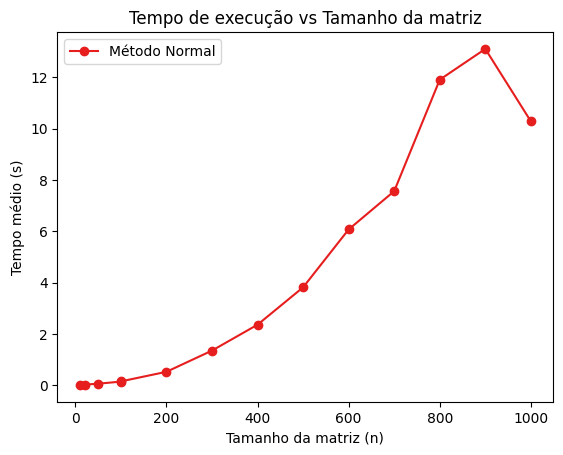

In [278]:
def tempo_medio_hessemberg(n, func, device='cpu', dtype=precision, symetric=False, computeQ=True):
    """
    Mede o tempo médio de execução da transformação de Hessenberg para uma matriz de tamanho n.

    Parâmetros:
    - n (int): dimensão da matriz quadrada.
    - func (function): função que realiza a transformação (ex: HS ou HS_symetric).
    - device (str): 'cpu' ou 'cuda' para indicar onde executar a operação.
    - dtype: tipo de dado dos tensores (ex: torch.float64).
    - symetric (bool): se True, gera matriz simétrica.

    Retorna:
    - tempo médio por execução (float)
    - v_list: lista de vetores de Householder usados
    - H: matriz Hessenberg resultante
    - Q: matriz ortogonal acumulada das reflexões
    - A: matriz original usada para teste
    """
    # Gera matriz aleatória no dispositivo e tipo definidos
    A = torch.rand((n, n), dtype=dtype, device=device)
    if symetric:
        A = (A + A.conj().T) / 2  # Simetriza a matriz, se solicitado

    start = time.time()
    count = 0
    elapsed = 0

    # Executa transformações repetidamente até que passe 1 segundo
    while elapsed < 1.0:
        v_list, H, Q = func(A.clone(), computeQ=computeQ)  # Usa cópia para não modificar A
        count += 1
        elapsed = time.time() - start

    # Retorna tempo médio por execução e os resultados da última execução
    return elapsed / count, v_list, H, Q, A


# Inicializa listas para armazenar resultados
tempos = [[],[]]
list_norm1 = [[],[]]  # ||A - QHQ^T||
list_norm2 = [[],[]]  # ||Q^T Q - I||

for n in ns:
    # Mede tempo e realiza transformação para matriz de tamanho n usando função HS
    t_medio, v_list, H, Q, A = tempo_medio_hessemberg(n, HS, computeQ=True)
    tempos[0].append(t_medio)

    # Calcula norma do erro de reconstrução A ≈ Q H Q^T
    norm1A = norm1(A, H, Q)
    # Calcula quão ortogonal é Q: Q^T Q ≈ I
    norm2A = norm2(Q)
    list_norm1[0].append(norm1A)
    list_norm2[0].append(norm2A)

    print(f"n = {n}, tempo médio algoritmo normal = {t_medio:.6f} segundos")

# Plota tempo médio de execução em função do tamanho da matriz
plt.plot(ns, tempos[0], 'o-', label='Método Normal', color=colorNormal)
plt.xlabel("Tamanho da matriz (n)")
plt.ylabel("Tempo médio (s)")
plt.title("Tempo de execução vs Tamanho da matriz")
plt.legend()
plt.show()


In [279]:

logs_n = np.log(ns)
logs_t = np.log(tempos[0])
slope, intercept, *_ = linregress(logs_n, logs_t)

print(f"Complexidade estimada: O(n^{slope:.2f})")




Complexidade estimada: O(n^1.68)


## d) Algoritmo para matrizes simétricas

No algoritmo atual, não há diferenciação de matrizes simétricas e assimétricas, ou seja, a tarefa computacional é a mesma para ambas.
Podemos tentar explorar a simetria das matrizes simétricas para otimizar e acelerar este cálculo.

### Ideia
- Para matrizes simétricas, não é necessário calcular algumas partes das matrizes geradas ao longo das iterações:
    - Ao mesmo tempo que vamos "ignorando" as colunas na multiplicação à esquerda podemos ignorar as linhas na multiplicação à direita. Isto é válido, pois a matriz permanece simétrica em todos os passos da iteração, então zeros são introduzidos ao mesmo tempo nas colunas quantos nas linhas simétricas a elas.
- Assim, iremos reduzir nosso custo computacional para $O(\frac{4}{3}m^3)$

### Implementação
- Para colocar em prática a nossa ideia, iremos implementar da seguinte forma:
    - ignorar as linhas da matriz $A$ conforme as iterações vão aumentando.
    - Ao fim das iterações, copiar o triângulo inferior da matriz obtida para o superior. 

### Resultado 
- Para o novo método, é observado uma real otimização de tempo. Para matrizes de ordem 5000 houve uma diferença de aproximadamente 100 segundos de diferença, o que representa um grande avanço.

In [280]:
def HS_symetric(A: torch.Tensor, computeQ=True):
    """
    Transforma uma matriz A em forma de Hessenberg usando reflexões de Householder.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada real ou complexa de dimensão (m x m)

    Retorna:
    - v_list: lista de vetores de Householder aplicados (um por iteração)
    - H: matriz de Hessenberg superior resultante (semelhante a A)
    - Q: matriz ortogonal/acumulada das reflexões, tal que Q^T A Q = H
    """
    m = A.shape[0]
    H = A.clone()  # Cópia da matriz original para evitar modificações diretas
    v_list = []    # Lista para armazenar os vetores de Householder
    if computeQ: Q = torch.eye(m, dtype=A.dtype, device=A.device)  # Inicializa Q como identidade

    for k in range(m - 2):
        # Seleciona a coluna abaixo da diagonal para zerar
        x = H[k+1 : m, k]
        v_k = x.clone()

        # Calcula o vetor de Householder
        norm_x = torch.norm(x)
        if x[0] != 0:
            phase = x[0] / torch.abs(x[0])  # Fator de fase: x[0]/|x[0]|
            v_k[0] += phase * norm_x
        else:
            v_k[0] += norm_x

        # Normaliza v_k
        v_k = v_k / torch.norm(v_k)
        v_list.append(v_k)

        # Aplica reflexão de Householder à esquerda: H = (I - 2vvᵗ) H
        left_mul = torch.matmul(v_k.conj().unsqueeze(0), H[k+1 : m, k : m])
        H[k+1 : m, k : m] -= 2 * torch.ger(v_k, left_mul.squeeze(0))

        # Aplica reflexão à direita: H = H (I - 2vvᵗ)
        right_mul = torch.matmul(H[k+1:, k+1 : m], v_k)
        H[k+1:, k+1 : m] -= 2 * torch.ger(right_mul, v_k.conj())

        if computeQ:
            # Atualiza a matriz Q acumulando as transformações
            q_mul = torch.matmul(Q[:, k+1:m], v_k)
            Q[:, k+1:m] -= 2 * torch.ger(q_mul, v_k.conj())
    # print(H)
    # print(torch.tril(H, 1))
    H = torch.tril(H) + torch.tril(H, -1).conj().T
    # print(H)
    if computeQ:
        return v_list, H, Q
    else:
        return v_list, H
    
def HS_symmetric_optimized(A: torch.Tensor, computeQ=True):
    """
    Transforma uma matriz A em forma de Hessenberg usando reflexões de Householder.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada real ou complexa de dimensão (m x m)

    Retorna:
    - v_list: lista de vetores de Householder aplicados (um por iteração)
    - H: matriz de Hessenberg superior resultante (semelhante a A)
    - Q: matriz ortogonal/acumulada das reflexões, tal que Q^T A Q = H
    """
    m = A.shape[0]
    H = A.clone()  # Cópia da matriz original para evitar modificações diretas
    v_list = []    # Lista para armazenar os vetores de Householder
    if computeQ: Q = torch.eye(m, dtype=A.dtype, device=A.device)  # Inicializa Q como identidade

    for k in range(m - 2):
        # Seleciona a coluna abaixo da diagonal para zerar
        x = H[k+1 : m, k]
        v_k = x.clone()

        # Calcula o vetor de Householder
        norm_x = torch.norm(x)
        if x[0] != 0:
            phase = x[0] / torch.abs(x[0])  # Fator de fase: x[0]/|x[0]|
            v_k[0] += phase * norm_x
        else:
            v_k[0] += norm_x

        # Normaliza v_k
        v_k = v_k / torch.norm(v_k)
        v_list.append(v_k)

        p = 2 * torch.mv(H[k+1:m, k+1:m], v_k)
        w = p - torch.dot(p.conj(), v_k) * v_k

        # Aplica a atualização que equivale a P*H*P, mas de forma mais eficiente
        H[k+1:m, k+1:m] -= (torch.ger(v_k, w.conj()) + torch.ger(w, v_k.conj()))

        H[k+1, k] = - phase * norm_x
        H[k, k+1] = -(phase * norm_x).conj()
        if k + 2 < m:
            H[k+2:m, k] = 0.0
            H[k, k+2:m] = 0.0

        if computeQ:
            # Atualiza a matriz Q acumulando as transformações
            q_mul = torch.matmul(Q[:, k+1:m], v_k)
            Q[:, k+1:m] -= 2 * torch.ger(q_mul, v_k.conj())
    # print(H)
    # print(torch.tril(H, 1))
    # H = torch.tril(H) + torch.tril(H, -1).conj().T
    # print(H)
    if computeQ:
        return v_list, H, Q
    else:
        return v_list, H
    

A = torch.randn((4,4), dtype=precision)
A = (A + A.conj().T) / 2

_, H, Q = HS_symmetric_optimized(A)

print(norm1(A, H, Q))

1.074789644834497e-15


n = 10, tempo médio algoritmo simetrica = 0.003749 segundos
n = 10, tempo médio algoritmo simetrica otimizado = 0.003781 segundos
__________________________________________________
n = 20, tempo médio algoritmo simetrica = 0.007281 segundos
n = 20, tempo médio algoritmo simetrica otimizado = 0.008525 segundos
__________________________________________________
n = 50, tempo médio algoritmo simetrica = 0.021454 segundos
n = 50, tempo médio algoritmo simetrica otimizado = 0.023716 segundos
__________________________________________________
n = 100, tempo médio algoritmo simetrica = 0.053236 segundos
n = 100, tempo médio algoritmo simetrica otimizado = 0.058947 segundos
__________________________________________________
n = 100, tempo médio algoritmo simetrica = 0.056769 segundos
n = 100, tempo médio algoritmo simetrica otimizado = 0.057516 segundos
__________________________________________________
n = 200, tempo médio algoritmo simetrica = 0.257003 segundos
n = 200, tempo médio algoritmo

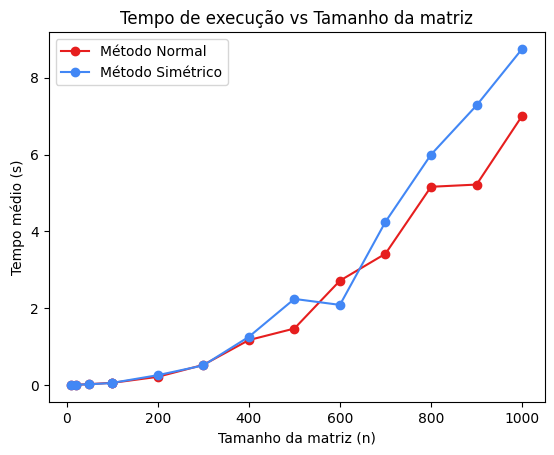

ValueError: x and y must have same first dimension, but have shapes (14,) and (42,)

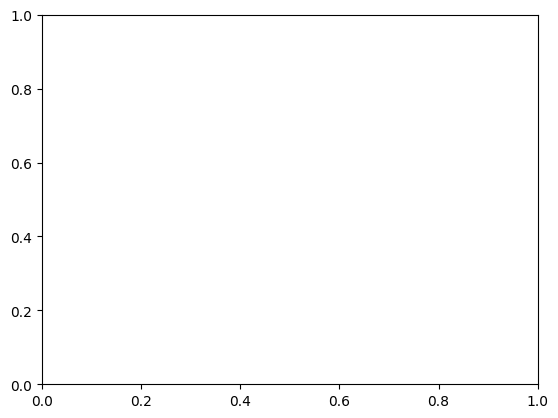

In [ ]:
tempos = [[],[]]
ns = [500,700,900,1100,1300,1500]
for n in ns:
    t_medio1, v_list, H_simetrica, Q_simetrica, A_simetrica = tempo_medio_hessemberg(n, HS_symetric, symetric=True)
    tempos[1].append(t_medio1)
    norm1A_simetrica = norm1(A_simetrica, H_simetrica, Q_simetrica)
    norm2A_simetrica = norm2(Q_simetrica)
    list_norm1[1].append(norm1A_simetrica)
    list_norm2[1].append(norm2A_simetrica)
    print(f"n = {n}, tempo médio algoritmo simetrica = {t_medio1:.6f} segundos")
    
    t_medio1, v_list, H_simetrica, Q_simetrica, A_simetrica = tempo_medio_hessemberg(n, HS_symmetric_optimized, symetric=True)
    tempos[0].append(t_medio1)
    norm1A_simetrica = norm1(A_simetrica, H_simetrica, Q_simetrica)
    norm2A_simetrica = norm2(Q_simetrica)
    list_norm1[0].append(norm1A_simetrica)
    list_norm2[0].append(norm2A_simetrica)
    print(f"n = {n}, tempo médio algoritmo simetrica otimizado = {t_medio1:.6f} segundos")
    print('_'*50)


plt.plot(ns, tempos[0], 'o-', label='Método Normal', color=colorNormal)
plt.plot(ns, tempos[1], 'o-', label='Método Simétrico', color=colorSymetric)
plt.xlabel("Tamanho da matriz (n)")
plt.ylabel("Tempo médio (s)")
plt.title("Tempo de execução vs Tamanho da matriz")
plt.legend()
plt.show()

# Gráfico da norma ||A - QHQ*||
# plt.subplot(1, 3, 2)
plt.plot(ns, list_norm1[0], 'o-', label="Método Normal", color=colorNormal)
plt.plot(ns, list_norm1[1], 'o-', label="Método Simétrico", color=colorSymetric)
plt.xlabel("Tamanho da matriz")
plt.ylabel("Norma")
plt.title("||A - QHQ*||")
plt.legend()
plt.show()
# Gráfico da norma ||Q*Q - I||
# plt.subplot(1, 3, 3)
plt.plot(ns, list_norm2[0], 'o-', label="Método Normal", color=colorNormal)
plt.plot(ns, list_norm2[1], 'o-', label="Método Simétrico", color=colorSymetric)
plt.xlabel("Tamanho da matriz")
plt.ylabel("Norma")
plt.title("||Q*Q - I||")
plt.legend()

plt.tight_layout()
plt.show()

n = 10, tempo médio algoritmo simetrica = 0.003570 segundos
n = 20, tempo médio algoritmo simetrica = 0.008538 segundos
n = 50, tempo médio algoritmo simetrica = 0.023583 segundos
n = 100, tempo médio algoritmo simetrica = 0.060311 segundos
n = 100, tempo médio algoritmo simetrica = 0.058217 segundos
n = 200, tempo médio algoritmo simetrica = 0.221532 segundos
n = 300, tempo médio algoritmo simetrica = 0.442527 segundos
n = 400, tempo médio algoritmo simetrica = 0.811116 segundos
n = 500, tempo médio algoritmo simetrica = 1.423343 segundos
n = 600, tempo médio algoritmo simetrica = 1.961162 segundos
n = 700, tempo médio algoritmo simetrica = 3.096142 segundos
n = 800, tempo médio algoritmo simetrica = 4.178134 segundos
n = 900, tempo médio algoritmo simetrica = 5.763670 segundos
n = 1000, tempo médio algoritmo simetrica = 7.764264 segundos


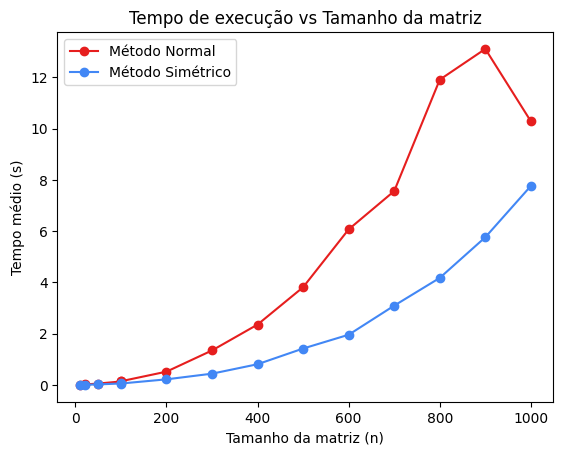

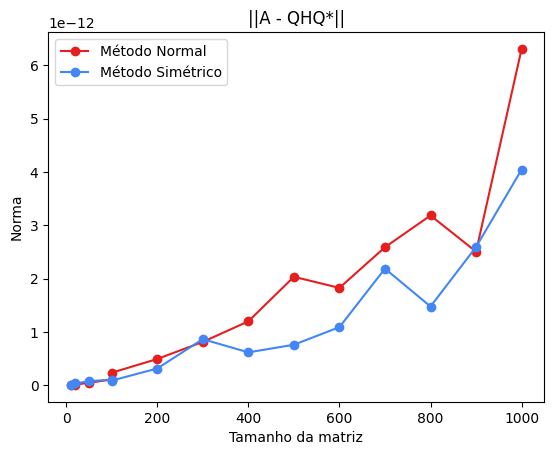

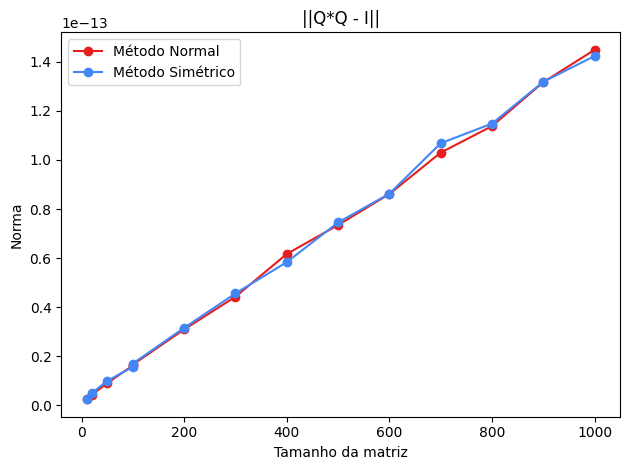

In [ ]:
for n in ns:
    t_medio1, v_list, H_simetrica, Q_simetrica, A_simetrica = tempo_medio_hessemberg(n, HS_symetric, symetric=True)
    tempos[1].append(t_medio1)
    norm1A_simetrica = norm1(A_simetrica, H_simetrica, Q_simetrica)
    norm2A_simetrica = norm2(Q_simetrica)
    list_norm1[1].append(norm1A_simetrica)
    list_norm2[1].append(norm2A_simetrica)
    print(f"n = {n}, tempo médio algoritmo simetrica = {t_medio1:.6f} segundos")


# Criação dos gráficos
# plt.figure(figsize=(18, 4))

# Gráfico de tempo de execução
# plt.subplot(1, 3, 1)
plt.plot(ns, tempos[0], 'o-', label='Método Normal', color=colorNormal)
plt.plot(ns, tempos[1], 'o-', label='Método Simétrico', color=colorSymetric)
plt.xlabel("Tamanho da matriz (n)")
plt.ylabel("Tempo médio (s)")
plt.title("Tempo de execução vs Tamanho da matriz")
plt.legend()
plt.show()

# Gráfico da norma ||A - QHQ*||
# plt.subplot(1, 3, 2)
plt.plot(ns, list_norm1[0], 'o-', label="Método Normal", color=colorNormal)
plt.plot(ns, list_norm1[1], 'o-', label="Método Simétrico", color=colorSymetric)
plt.xlabel("Tamanho da matriz")
plt.ylabel("Norma")
plt.title("||A - QHQ*||")
plt.legend()
plt.show()
# Gráfico da norma ||Q*Q - I||
# plt.subplot(1, 3, 3)
plt.plot(ns, list_norm2[0], 'o-', label="Método Normal", color=colorNormal)
plt.plot(ns, list_norm2[1], 'o-', label="Método Simétrico", color=colorSymetric)
plt.xlabel("Tamanho da matriz")
plt.ylabel("Norma")
plt.title("||Q*Q - I||")
plt.legend()

plt.tight_layout()
plt.show()

In [282]:

logs_n = np.log(ns)
logs_t0 = np.log(tempos[0])
logs_t1 = np.log(tempos[1])
slope0, intercept, *_ = linregress(logs_n, logs_t0)
slope1, intercept, *_ = linregress(logs_n, logs_t1)

print(f"Complexidade estimada para normal: O(n^{slope0:.2f})")
print(f"Complexidade estimada para simetrica: O(n^{slope1:.2f})")



Complexidade estimada para normal: O(n^1.68)
Complexidade estimada para simetrica: O(n^1.70)


# Questão 2. Matrizes Ortogonais.

## a) Um pouco de teoria. 

### i. O que você pode dizer dos autovalores de uma matriz ortogonal?
Seja $A$ uma matriz ortogonal e $v$ um autovetor associado à esta matriz, ou seja, 

$$
A^TA = I
$$

e
$$
Av = \lambda v
$$

Podemos realizar um pequeno truque:

$$
v^Tv = (Av)^T(Av) = \lambda v^T \lambda v = \lambda^2 v^Tv
$$

implicando em 

$$
v^Tv = \lambda^2 v^Tv
$$

como $v^tv$ é sempre maior do que zero, então

$$
|\lambda| = 1
$$

ou seja, 

$$
\lambda = e^{i\phi}, \phi \isin \R
$$


### ii.

- Repare que se $x$ é um vetor no espaço, então $||Ax|| = ||x||$, pois $A$ é ortogonal. Assim podemos ver que estamos apenas rotacionando nosso vetor no espaço, sem alongar ou contrair ele.
- A cada iteração, aplicamos $||Ax^{(k)}||$, sempre rotacionando $x$ no círculo unitário.
- Como não existe um autovalor dominante, ou seja, de maior módulo, o algoritmo pode não convergir. Em vez disso, a sequência de autovetores pode oscilar ou entrar em ciclos. 

In [283]:
def powerIteration(A: torch.Tensor, maxIteration: int = 10000, min_distance: float = 1e-16):
    """
    Aplica o método da potência para estimar o autovalor dominante (em módulo) da matriz A.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada de entrada.
    - maxIteration (int): número máximo de iterações (default: 10000).
    - min_distance (float): tolerância para convergência do autovalor (default: 1e-16).

    Retorna:
    - Aproximação do autovalor dominante (float).
    """
    A = A.to(dtype=precision)  # Garante que a matriz tenha a precisão definida
    v = torch.randn(A.shape[1], dtype=precision)  # Vetor inicial aleatório
    v = v / torch.norm(v, p=2)  # Normaliza o vetor inicial

    for i in range(maxIteration):
        w = torch.matmul(A, v)  # Multiplica A por v
        v2 = w / torch.norm(w)  # Normaliza o novo vetor
        λ1 = torch.dot(v.conj(), A @ v)     # Estima o autovalor antes da atualização
        λ2 = torch.dot(v2.conj(), A @ v2)   # Estima o autovalor após a atualização

        # Critério de convergência: diferença pequena entre estimativas consecutivas
        if abs(λ1 - λ2) < min_distance:
            print(f"Iterou por {i+1} vezes")
            break

        v = v2  # Atualiza v para a próxima iteração

    # Retorna a estimativa final do autovalor dominante
    return torch.dot(v.conj(), torch.matmul(A, v))


In [284]:
A = torch.randn((7,7),dtype=precision)
A = (A + A.T)/2
_,_,Q = HS_symetric(A)
Q = (Q + Q.T)/2
powerIteration(Q)

Iterou por 177 vezes


tensor(1.0000-4.4409e-16j, dtype=torch.complex128)

### iii.

- Em contra partida à necessidade de ter um autovalor dominante, com módulo maior que os outros, no algoritmo do método das potências, o método da iteração inversa não é limitado por esta condição. 

In [285]:
def inverseIteration(A: torch.Tensor, maxIteration: int=10000, min_distance: float=1e-16, u=None, printIterations=False):
    """
    Realiza o método da iteração inversa para encontrar um autovalor dominante próximo ao shift u.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada.
    - maxIteration (int): número máximo de iterações (default: 10000).
    - min_distance (float): tolerância mínima para a convergência do autovalor (default: 1e-16).
    - u (float ou None): shift (valor estimado próximo ao autovalor desejado). Se None, um aleatório é usado.
    - printIterations (bool): se True, imprime o número de iterações realizadas.

    Retorna:
    - lmb1 (float): autovalor aproximado.
    - i (int): número de iterações realizadas.
    """
    # Se nenhum shift for fornecido, usa um aleatório
    if u is None:
        u = float(random.random())

    # Garante o tipo e precisão corretos
    A = A.to(dtype=precision)

    # Dimensão da matriz
    n = A.shape[1]

    # Vetor inicial normalizado
    v = torch.randn(n, dtype=precision)
    v = v / torch.norm(v, p=2)

    # Matriz (A - uI) que será invertida
    A_ = A - u * torch.eye(n, dtype=precision)

    # Inicia iteração inversa
    for i in range(maxIteration):
        # Resolve (A - uI)w = v
        w = torch.linalg.solve(A_, v)

        # Normaliza w para obter novo vetor v2
        v2 = w / torch.norm(w)

        # Aproximação do autovalor com produto de Rayleigh
        lmb1 = torch.dot(v.conj(), A @ v)
        lmb2 = torch.dot(v2.conj(), A @ v2)

        # Critério de convergência
        if abs(lmb1 - lmb2) < min_distance:
            break

        # Atualiza v para a próxima iteração
        v = v2

    if printIterations:
        print(f"Iterou por {i+1} vezes")

    return lmb1, i


In [286]:
A = torch.randn((40,40),dtype=precision)
lmb, iter = inverseIteration(A)    
# A = (A + A.T)/2

# Comparar com os autovalores reais
eigvals = torch.linalg.eigvals(A)
diffs = torch.abs(eigvals - lmb)
closest_idx = torch.argmin(diffs)
closest_val = eigvals[closest_idx]
error = diffs[closest_idx]

print(f"\nAproximado: {lmb}")
print(f"Autovalor mais próximo: {closest_val}")
print(f"Erro absoluto: {error.item()}")






Aproximado: (-0.1787948567993231+0.7187931570511608j)
Autovalor mais próximo: (-0.1787948567993218+0.7187931570511575j)
Erro absoluto: 3.47388500551334e-15


## b) Calculando os autovalores de $ A=\begin{pmatrix}  a & b \\  c & d \\\end{pmatrix} $


Queremos um $\lambda$ tal que $det(A - \lambda I) = 0$, então podemos abrir as contas:

$$
(a - \lambda)(d-\lambda) = bc
$$
então,
$$
\lambda^2 - (a + d)\lambda + ad - bc = 0
$$
logo, podemos concluir que
$$
\lambda \isin \set{\frac{a + d \pm \sqrt{(a + d)^2 -4(ad - bc)}}{2}}
$$

Agora, supondo que $A$ é ortogonal, temos a relação

$$
\det(A) \isin \set{-1, 1}
$$

logo 

$$
ad - bc \isin \set{-1, 1}
$$







In [287]:
def eigenValues22(A: torch.Tensor):
    """
    Calcula os autovalores de uma matriz 2x2 utilizando a fórmula do polinômio característico.

    Parâmetros:
    - A (torch.Tensor): matriz 2x2.

    Retorna:
    - tuple (lambda_1, lambda_2): autovalores (possivelmente complexos).
    """
    # Garante que A esteja com a precisão desejada
    A = A.to(dtype=precision)

    # Elementos da matriz
    a, b = A[0][0], A[0][1]
    c, d = A[1][0], A[1][1]

    # Traço e determinante
    trA = a + d
    detA = a * d - b * c

    # Discriminante do polinômio característico
    delta = trA ** 2 - 4 * detA

    # Fórmula resolvente para raízes do polinômio de segundo grau
    return ((trA - torch.sqrt(delta)) / 2, (trA + torch.sqrt(delta)) / 2)


def testEigens(A: torch.Tensor, lmbs: torch.Tensor):
    """
    Testa se os valores fornecidos são autovalores da matriz A, imprimindo |det(A - λI)| para cada λ.

    Parâmetros:
    - A (torch.Tensor): matriz quadrada de entrada.
    - lmbs (torch.Tensor): autovalores aproximados ou estimados.

    Esta função imprime:
    - O valor de cada λ.
    - Sua norma (módulo).
    - O determinante de (A - λI), que idealmente deve ser zero.
    """
    A = A.to(dtype=precision)
    I = torch.eye(A.shape[0], dtype=precision)

    print('_' * 100 + '\n')
    for index, lmb in enumerate(lmbs):
        # Calcula determinante de (A - λI)
        det_val = torch.linalg.det(A - lmb * I)

        # Exibe informações detalhadas
        print(f"lambda_{index}: {lmb:.4e}")
        print(f"        . Norma de lambda_{index}= {torch.linalg.norm(lmb)}")
        print(f"        . det(A - λI)= {det_val:4e}")
        print(f"        . |det(A - λI)|= {torch.abs(det_val):.4e}")
        print()



A = torch.tensor([
    [1, 2],
    [3, 2],
], dtype=precision)

eig = eigenValues22(A)

testEigens(A, eig)

____________________________________________________________________________________________________

lambda_0: -1.0000e+00+0.0000e+00j
        . Norma de lambda_0= 1.0
        . det(A - λI)= -0.000000e+00+0.000000e+00j
        . |det(A - λI)|= 0.0000e+00

lambda_1: 4.0000e+00+0.0000e+00j
        . Norma de lambda_1= 4.0
        . det(A - λI)= -0.000000e+00+0.000000e+00j
        . |det(A - λI)|= 0.0000e+00



## c) Testes com matrizes de ordem 4.

- É observado que, para os blocos 2x2 da parte inferior direita das matrizes Q_hessenberg, as normas dos autovalores tendem a ser 1, nunca passando desse valor.
- A distribuição dos autovalores no espaço seguem uma forma interessante: 
    - Sempre conjugados, ou seja, espelhados no eixo real
    - Tendem à terem a parte real negativa.

In [288]:
theta = np.linspace(0, 2 * np.pi, 100)
x_circle = np.cos(theta)
y_circle = np.sin(theta)


def plot_eigens_data(lmbs_list, title, s=1):
    """
    Plota os autovalores fornecidos em um gráfico complexo e um histograma dos seus módulos.

    Parâmetros:
    - lmbs_list (list[Tensor]): Lista de tensores de autovalores (complexos).
    - title (str): Título para os gráficos.
    - s (int, opcional): Tamanho dos pontos no gráfico de dispersão (default: 1).

    Geração de gráficos:
    - Subplot 1: autovalores no plano complexo, comparando com o círculo unitário.
    - Subplot 2: histograma dos módulos dos autovalores (|lambda|).
    """
    # Empilha a lista de tensores em um único tensor 1D de complexos
    lmbs_tensor = torch.stack(lmbs_list).to(dtype=precision)

    # Obtém partes reais, imaginárias e módulos dos autovalores
    moduli = torch.abs(lmbs_tensor)
    real_parts = lmbs_tensor.real
    imag_parts = lmbs_tensor.imag

    # Define número de bins para o histograma (poderia ser adaptativo, mas aqui fixamos)
    num_bins = 100

    # Inicia figura com 2 subplots
    plt.figure(figsize=(12, 6))

    # Subplot 1: gráfico de dispersão no plano complexo
    plt.subplot(1, 2, 1)
    plt.scatter(real_parts, imag_parts, s=s, alpha=0.6, label=title)
    plt.plot(x_circle, y_circle, 'r--', label='Círculo Unitário (|λ|=1)', alpha=0.3)
    plt.axis('equal')
    plt.xlabel('Parte Real (λ)')
    plt.ylabel('Parte Imaginária (λ)')
    plt.grid(True)
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.title(title)
    plt.legend()

    # Subplot 2: histograma dos módulos
    plt.subplot(1, 2, 2)
    plt.hist(moduli.numpy(), bins=num_bins, color='skyblue', edgecolor='black')
    plt.axvline(1.0, color='red', linestyle='--', label='|λ| = 1', linewidth=1, alpha=0.5)
    plt.xlabel('|λ| (módulo)')
    plt.ylabel('Frequência')
    plt.title(f"Histograma dos módulos - {title}")
    plt.legend()
    plt.grid(True)

    # Mostra os gráficos
    plt.show()


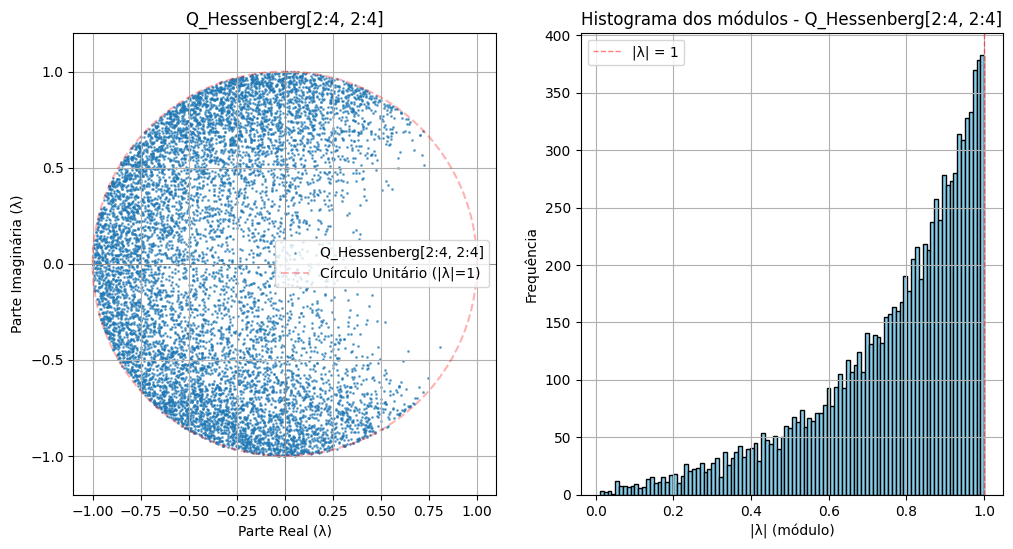

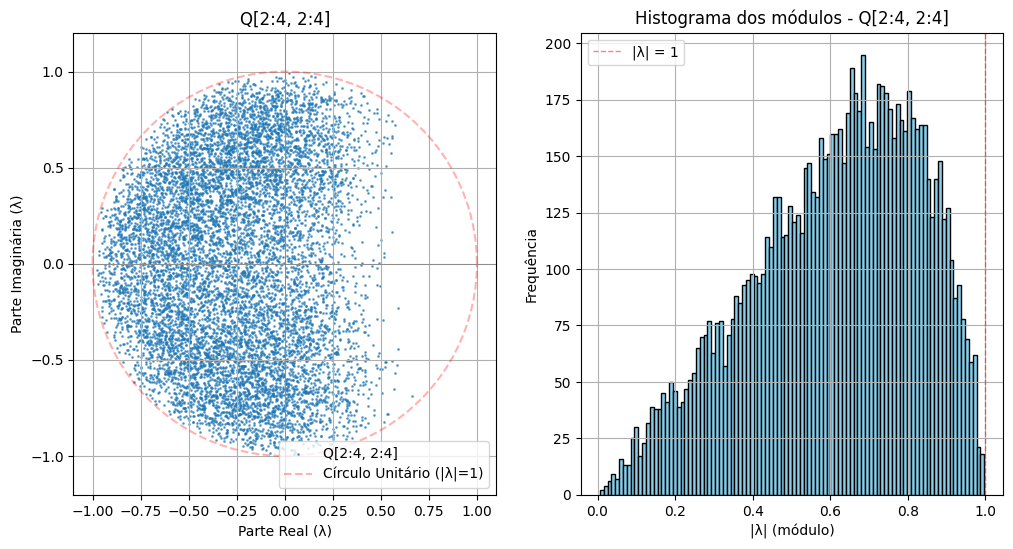

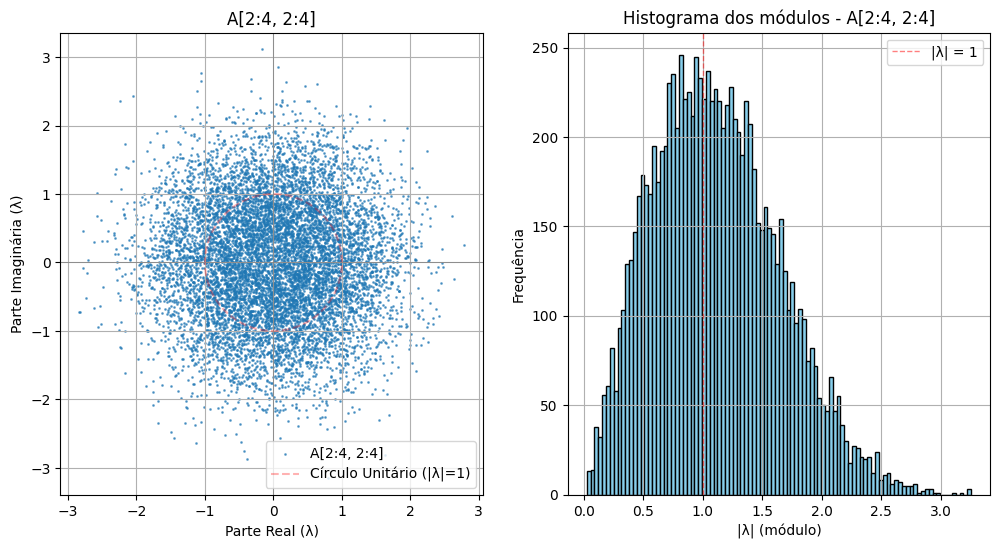

In [289]:
num_max = 5000


norms = []
lmbs_list_Q_hessenberg = []
lmbs_list_A = []
lmbs_list_Q = []

for i in range(num_max):
    A = torch.randn((4,4), dtype=precision)
    Q, _= torch.linalg.qr(A)
    _, Q_Hessenberg, _ = HS(Q)

    lmbs = eigenValues22(Q_Hessenberg[2:4, 2:4])
    lmbs_list_Q_hessenberg.append(lmbs[0])
    lmbs_list_Q_hessenberg.append(lmbs[1])
    lmbs = eigenValues22(A[2:4, 2:4])
    lmbs_list_A.append(lmbs[0])
    lmbs_list_A.append(lmbs[1])
    lmbs = eigenValues22(Q[2:4, 2:4])
    lmbs_list_Q.append(lmbs[0])
    lmbs_list_Q.append(lmbs[1])

plot_eigens_data(lmbs_list_Q_hessenberg, "Q_Hessenberg[2:4, 2:4]")
plot_eigens_data(lmbs_list_Q, "Q[2:4, 2:4]")
plot_eigens_data(lmbs_list_A, "A[2:4, 2:4]")






## d) Shifts.

- Para analisar os benefícios de usar um autovalor do bloco 2x2 como shift, iremos contar o número de iterações e a distância da resposta ideal.
    - Ambas as análises serão feitas em um bloxplot.
- Fica claro que, usando o autovalor do bloco 2x2 inferior direito, especificamente, o mais próximo do último elemento direito da diagonal principal, o algoritmo da iteração QR passa a convergir muito mais e obter um resultado muito mais favorável na maioria dos casos.


In [290]:
def practicalQR(A, maxIter=1000, tol=1e-12, printSteps=False, u=None, countOnly=False, trackSubdiag=False):
    """
    Executa o algoritmo QR prático com ou sem shift para encontrar os autovalores de uma matriz.

    Parâmetros:
    - A (tensor 2D): Matriz quadrada (idealmente em forma de Hessenberg).
    - maxIter (int): Número máximo de iterações permitidas (padrão: 1000).
    - tol (float): Tolerância para considerar elementos da subdiagonal como zero (padrão: 1e-12).
    - printSteps (bool): Se True, imprime aviso caso o número máximo de iterações seja atingido.
    - u (float, opcional): Valor de shift para acelerar a convergência. Se None, usa A[-1, -1].
    - countOnly (bool): Se True, a função retorna apenas o número de iterações (não usado diretamente aqui).
    - trackSubdiag (bool): Se True, armazena e acompanha as normas dos elementos subdiagonais a cada iteração.

    Retorno:
    - (list[float], int): Lista de autovalores aproximados e o número de iterações realizadas.
    """
    A = A.clone().to(dtype=precision)  # Garante cópia da matriz e tipo numérico desejado
    n = A.shape[0]
    subdiag_norms = []

    # Caso base: matriz 1x1
    if n == 1:
        return [A[0, 0]], 0

    # Caso base: matriz 2x2 — calcula os autovalores analiticamente
    if n == 2:
        tr = A[0, 0] + A[1, 1]
        det = A[0, 0]*A[1, 1] - A[0, 1]*A[1, 0]
        delta = torch.sqrt(tr**2 - 4*det)
        return [(tr + delta)/2, (tr - delta)/2], 0

    iter_count = 0
    while iter_count < maxIter:
        if trackSubdiag:
            # Armazena norma dos elementos subdiagonais
            subdiag_norms.append(A[1:, :-1].diagonal().abs().tolist())

        # Verifica convergência por elementos pequenos na subdiagonal
        for p in reversed(range(n - 1)):
            if abs(A[p+1, p]) < tol:
                # Força o elemento a ser zero e divide o problema em blocos
                A[p+1, p] = A[p, p+1] = 0.0
                eigs1, c1 = practicalQR(A[:p+1, :p+1], maxIter, tol, printSteps, u, countOnly)
                eigs2, c2 = practicalQR(A[p+1:, p+1:], maxIter, tol, printSteps, u, countOnly)
                return eigs1 + eigs2, iter_count + c1 + c2

        # Aplicação do shift (valor padrão: canto inferior direito)
        if u is None:
            u = A[-1, -1]
        Q, R = torch.linalg.qr(A - u * torch.eye(n, dtype=A.dtype))
        A = R @ Q + u * torch.eye(n, dtype=A.dtype)

        iter_count += 1

    if printSteps:
        print("Aviso: número máximo de iterações atingido")

    # Retorna os elementos da diagonal principal como autovalores
    return [A[i, i] for i in range(n)], iter_count



def autovalor_erro(aprox_vals, true_vals):
    """
    Calcula o erro entre os autovalores aproximados e os autovalores reais.

    Os autovalores são ordenados e considerados apenas suas partes reais.
    A função retorna a norma da diferença entre os vetores ordenados de autovalores.

    Parâmetros:
    - aprox_vals (iterável): Lista ou tensor com os autovalores aproximados (possivelmente complexos).
    - true_vals (iterável): Lista ou tensor com os autovalores verdadeiros (possivelmente complexos).

    Retorno:
    - float: Erro (norma 2) entre os autovalores reais aproximados e os reais verdadeiros.
    """
    aprox_vals_sorted = torch.sort(torch.real(torch.tensor(aprox_vals)))[0]
    true_vals_sorted = torch.sort(torch.real(true_vals))[0]
    return torch.linalg.norm(aprox_vals_sorted - true_vals_sorted).item()



In [291]:
erros_shift_bom = []
erros_shift_aleatorio = []
iters_random_list = []
iters_shift_list = []


for i in range(num_max):
    # Matriz ortogonal
    A = torch.randn((4,4))
    Q, _ = torch.linalg.qr(A)
    
    # Forma de Hessenberg
    _, Q_Hessenberg, _ = HS(Q)

    # Shift a partir do bloco 2x2 final
    lmb0, lmb1 = eigenValues22(Q_Hessenberg[2:4, 2:4]) 
    lmb_bom = lmb0 if torch.linalg.norm(lmb0 - Q_Hessenberg[3,3]) < torch.linalg.norm(lmb1 - Q_Hessenberg[3,3]) else lmb1

    # Autovalores reais (torch)
    true_eigs = torch.linalg.eigvals(Q_Hessenberg)

    # Com shift bom
    eigs_bom, iters_shift = practicalQR(Q_Hessenberg, u=lmb_bom)
    erro_shift = autovalor_erro(eigs_bom, true_eigs)
    erros_shift_bom.append(erro_shift)
    iters_shift_list.append(iters_shift)

    # Com shift aleatório
    eigs_aleat, iters_random = practicalQR(Q_Hessenberg)
    erro_aleat = autovalor_erro(eigs_aleat, true_eigs)
    erros_shift_aleatorio.append(erro_aleat)
    iters_random_list.append(iters_random)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.boxplot([erros_shift_aleatorio, erros_shift_bom], tick_labels=["Shift aleatório", "Shift do bloco"])
plt.title("Erro dos autovalores obtidos (vs. reais)")
plt.ylabel("Norma da diferença")
plt.grid(True)
plt.yscale("log")  # escala log para mostrar diferenças pequenas

plt.subplot(1,2,2)
plt.boxplot([iters_random_list, iters_shift_list], tick_labels=['Sem shift', 'Com shift'])
plt.title('Distribuição de iterações QR')
plt.ylabel('Número de iterações')
plt.grid(True)

plt.show()
print(f"Erro médio com shift aleatório: {sum(erros_shift_aleatorio)/num_max:.2e}")
print(f"Erro médio com shift do bloco: {sum(erros_shift_bom)/num_max:.2e}")
print(f"Número de iterações médias com shift aleatório: {sum(iters_random_list)/num_max}")
print(f"Número de iterações médias com shift do bloco: {sum(iters_shift_list)/num_max}")




KeyboardInterrupt: 


---

### Ideia
- Para matrizes simétricas, não é necessário calcular algumas partes das matrizes geradas ao longo das iterações:
    - Ao aplicar o refletor à direita, somente será necessário calcular as entradas da parte triangular inferior da matriz H, pois a matriz se mantém simétrica durante todas as iterações.

### Obstáculo
- Tal ideia de otimização leva a crer que sempre teremos um algoritmo mais eficiente no final das contas, o que não é verdade sempre.
- O algoritmo HS_symetric tenta explorar as propriedades simétricas que ocorreriam durante os cálculos, porém, quando deixamos de apenas calcular o resultado de todas as entradas para computar somente aquelas que atendem aos nossos critérios, o algoritmo se mostra menos eficiente. 
- Isto se deve ao fato de que o PyTorch utilizado usa, de forma muito eficiente, o paralelismo da CPU/GPU. Então quando tentamos quebrar o processo de calcular uma matriz resultante de um produto em partes (somente a triangular inferior, superior, diagonal, ... ), esta nova chamada afeta a eficiência do paralelismo explorado pelo PyTorch.

### Conclusão
- Para que a otimização descrita tenha o efeito esperado precisamos que o algoritmo padrão da forma de Hessenberg seja tão ruim a ponto de permitir que o ato de selecionar o que calcular em nossa matriz torne o algoritmo mais eficiente. Isto não acontece neste projeto.